## Recommeder Model

In [1]:
#Use conda to install scikit-surprise with the below command
#conda install -c conda-forge scikit-surprise

#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#surprise imports
import surprise
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

## Load Data

In [2]:
#load in csv data
raw_df = pd.read_csv('../../raw/input_runners_2020.csv')
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency
0,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,4.0,0.225806
1,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,6.0,0.677419
2,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,5.0,0.700000
3,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,6.0,0.466667
4,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,8.0,0.233333


In [4]:
#convert pace to minutes
raw_df['prev_month_weekly_pace'] = 60/raw_df['prev_month_weekly_pace']
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency
0,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,4.0,0.225806
1,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,6.0,0.677419
2,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,5.0,0.700000
3,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,6.0,0.466667
4,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,8.0,0.233333


In [5]:
#set "users" to athlete id + month

#convert months to number
def mtn(x):
    months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    a = x.strip()[:3].lower()
    try:
        ez = months[a]
        return ez
    except:
        raise ValueError('Not a month')
        
raw_df["current_month"] =  raw_df["current_month"].apply(lambda x:mtn(x)) 

#create user ID
raw_df["user_id"] = raw_df["athlete"].astype(str) + "." + raw_df["current_month"].astype(str)

In [6]:
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency,user_id
0,0,5.165000,4.973678,1.000000,18 - 34,F,United States,10,4.0,0.225806,0.10
1,0,5.165000,4.973678,1.000000,18 - 34,F,United States,10,6.0,0.677419,0.10
2,0,3.703333,3.424430,0.666667,18 - 34,F,United States,11,5.0,0.700000,0.11
3,0,3.703333,3.424430,0.666667,18 - 34,F,United States,11,6.0,0.466667,0.11
4,0,3.703333,3.424430,0.666667,18 - 34,F,United States,11,8.0,0.233333,0.11


## Input New User Info

### Key next steps:
 - Turn into callable functions
 - Build method to add/update data for existing user

In [6]:
#filter dataset based on targets
gender = "F"
weekly_target = 40
age_bucket = "18 - 34"
month = mtn("October")
number_of_days = 5
new_id = '000.0'

#cold start for new user. Assumes long run 2x distance other runs.
new_user_data = { 
    'user_id' : [new_id] * 2,
    'run_distance_rounded' : [round(weekly_target/6), round(weekly_target/3)],
    'weekly_frequency' : [number_of_days -1, 1]
                }
new_user_df = pd.DataFrame(new_user_data)
new_user_df

,user_id,run_distance_rounded,weekly_frequency
0,000.0,7,4
1,000.0,13,1


## Train Model Based on User Filters

### Key next steps:
 - Turn into callable functions

In [7]:
#define objects for Surprise. Must be in user, item, rating order
filtered_df = raw_df.loc[
    (raw_df['gender'] == gender) &
    (raw_df['age_bucket'] == age_bucket) &
    (raw_df['current_month'] == month) &
    (raw_df['prev_month_weekly_days_run'] > (number_of_days-1)) & 
    (raw_df['prev_month_weekly_days_run'] < (number_of_days+1)) &
    (raw_df['prev_month_weekly_km'] > weekly_target-5) &
    (raw_df['prev_month_weekly_km'] < weekly_target+5)
]

#append new user data

filtered_df = pd.concat([filtered_df,new_user_df])
    
data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

In [8]:
#train model with 3 fold cross validation
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4369  0.5781  0.6310  0.5487  0.0819  
MAE (testset)     0.3163  0.3725  0.3738  0.3542  0.0268  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.43691533, 0.57810945, 0.63099723]),
 'test_mae': array([0.31632868, 0.37251872, 0.37376181]),
 'fit_time': (0.001155853271484375,
  0.0010662078857421875,
  0.0010395050048828125),
 'test_time': (0.004535675048828125,
  0.0004932880401611328,
  0.0004916191101074219)}

In [9]:
#fit the model using the full dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [10]:
#generate recommendations by generating a list of run distances based on the average expected run lenghy

def generate_run_ratings(user_id, weekly_target, number_of_days, long_run_multiple = 3):
    
    """
    Generates a list of run distances with ratings based on weekly target, 
    number of days run each week, with an optional param that sets the upper 
    bound long run distance
    """
    
    #create list of run lengths
    run_list = range(round(weekly_target/(number_of_days+(long_run_multiple-1))), round((weekly_target/number_of_days) * long_run_multiple))
    results_dict = {'run_distance': [],
                   'run_rating': []}
    
    
    for run in run_list:
        rating_prediction = svd.predict(uid = user_id, iid = run)[3]
        results_dict['run_distance'].append(run)
        results_dict['run_rating'].append(rating_prediction)
        
    return pd.DataFrame(results_dict)


predictions = generate_run_ratings(new_id, weekly_target, number_of_days)

In [11]:
#sorted recommendations
predictions.sort_values(by=['run_rating'], ascending = False)

,run_distance,run_rating
1,7,1.380657
4,10,1.050828
2,8,0.759991
16,22,0.746501
0,6,0.732182
14,20,0.712666
12,18,0.712579
17,23,0.703654
13,19,0.702431
8,14,0.698284


## Model Evaluation

In [8]:
import time
import seaborn as sns

In [13]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        svd = SVD(verbose=False, n_epochs=10)
        validation = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

Finished in: 17.587813138961792
Finished in: 18.481093406677246
Finished in: 17.74460768699646
Finished in: 20.823495626449585
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 16.26993203163147
insufficient data for M 55 + 10
Finished in: 15.846834659576416


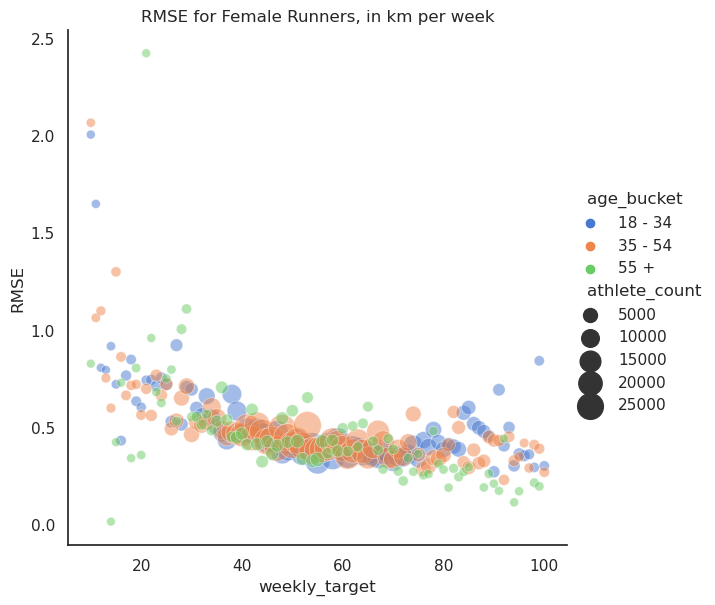

In [14]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

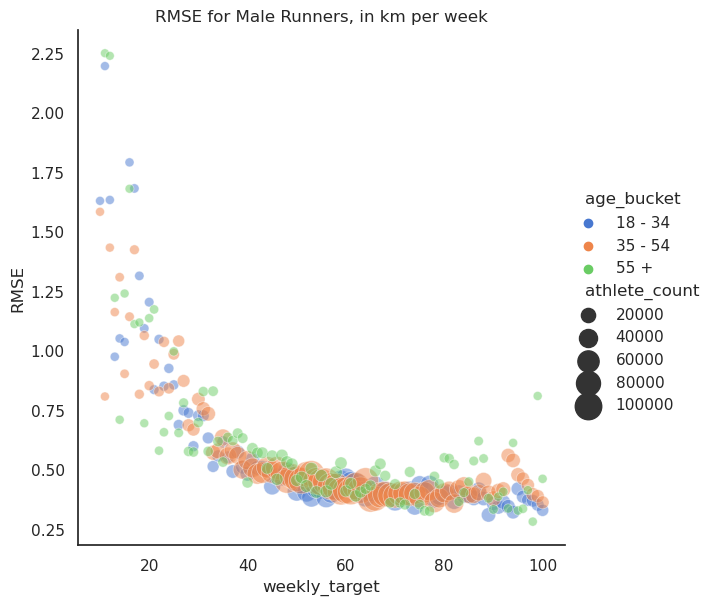

In [15]:
sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

### Weighted RMSE

For use to compare overall model performance

In [16]:
#calc weighted average RMSE for each set
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])
graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
df_SVD = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
df_SVD["Weighted_RMSE"] = df_SVD["RMSE_weight"]/df_SVD["athlete_count"]

In [17]:
df_SVD

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.885873e+05         899041       0.432224
           M       1.024192e+06        2362558       0.433510
35 - 54    F       4.638081e+05        1055890       0.439258
           M       1.953714e+06        4303695       0.453962
55 +       F       5.964933e+04         131450       0.453780
           M       2.384536e+05         481613       0.495115

### Baseline KNN

In [9]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        knn = KNNBasic(verbose=False)
        validation = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

Finished in: 18.3218355178833
Finished in: 26.17047429084778
Finished in: 18.92791438102722
Finished in: 47.705087423324585
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 15.301796436309814
insufficient data for M 55 + 10
Finished in: 15.144268035888672


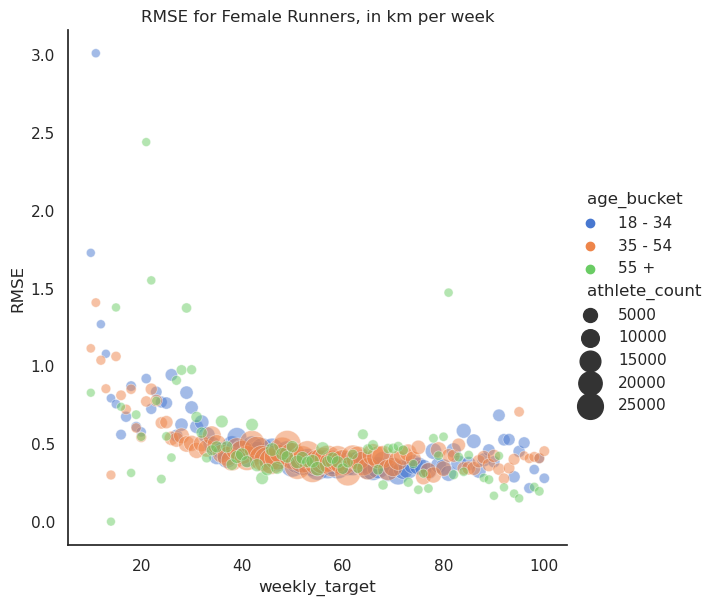

In [10]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

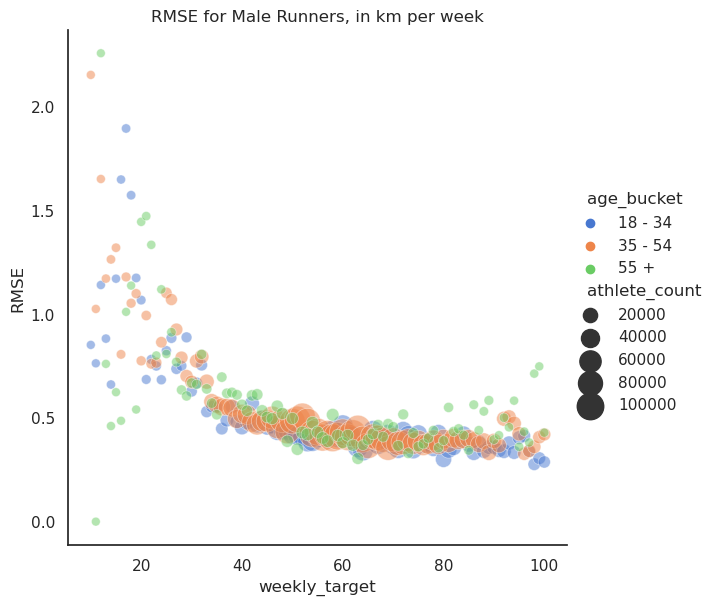

In [11]:
sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

In [21]:
#calc weighted average RMSE for each set
graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
df_KNN = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
df_KNN["Weighted_RMSE"] = df_KNN["RMSE_weight"]/df_KNN["athlete_count"]
df_KNN

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.721049e+05         899041       0.413891
           M       9.865497e+05        2362558       0.417577
35 - 54    F       4.507381e+05        1055890       0.426880
           M       1.937738e+06        4303695       0.450250
55 +       F       5.839384e+04         131450       0.444229
           M       2.374939e+05         481613       0.493122

In [22]:
df_SVD

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.885873e+05         899041       0.432224
           M       1.024192e+06        2362558       0.433510
35 - 54    F       4.638081e+05        1055890       0.439258
           M       1.953714e+06        4303695       0.453962
55 +       F       5.964933e+04         131450       0.453780
           M       2.384536e+05         481613       0.495115

### Grid Search Tuning

For tuning, we drop runners with minimal data. Those with 35km or less in weekly training

In [6]:
#restrict data to 35km and greater
tuning_df = raw_df.loc[(raw_df['prev_month_weekly_km'] >= 35)]

#### SVD Tuning

In [43]:
#SVD paramaters
SVDparam = {'n_factors': [20, 50, 80],
            'reg_all': [0.04, 0.06],
            'n_epochs': [10, 20, 30],
            'lr_all': [.022, .005, .01]}
gridSVD = GridSearchCV(SVD, param_grid=SVDparam, measures=["rmse"], cv=3, joblib_verbose = 1, n_jobs = 16)

data = Dataset.load_from_df(tuning_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

In [44]:
gridSVD.fit(data)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 162 out of 162 | elapsed:  1.9min finished


In [46]:
print('Best SVD results')
print(gridSVD.best_score['rmse'])
print(gridSVD.best_params['rmse'])

Best SVD results
0.39582782883944434
{'n_factors': 20, 'reg_all': 0.06, 'n_epochs': 10, 'lr_all': 0.005}


In [25]:
#confirm SVD results

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        knn = KNNBasic(n_factors = 20, reg_all = 0.06, n_epochs = 10, lr_all = 0.05, verbose=False)
        validation = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

#calc weighted average RMSE for each set
graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
df_SVD = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
df_SVD["Weighted_RMSE"] = df_SVD["RMSE_weight"]/df_SVD["athlete_count"]
df_SVD

Finished in: 18.771198749542236
Finished in: 26.840430974960327
Finished in: 19.664109230041504
Finished in: 47.80754375457764
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 16.056968212127686
insufficient data for M 55 + 10
Finished in: 15.840078592300415


RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       5.268901e+05         899041       0.586058
           M       1.500166e+06        2362558       0.634975
35 - 54    F       6.596807e+05        1055890       0.624763
           M       2.878691e+06        4303695       0.668888
55 +       F       7.578308e+04         131450       0.576516
           M       3.434801e+05         481613       0.713187

#### KNN Tuning

#### grid search freezes for KNN

In [7]:
'''
KNNparam = { 'k': [30, 40],
             'min_k': [1, 2]
           }

gridKNN = GridSearchCV(KNNBasic, param_grid=KNNparam, measures=["rmse"], joblib_verbose = 1)

data = Dataset.load_from_df(tuning_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))
'''

In [ ]:
#gridKNN.fit(data)

In [ ]:
'''
print('Best SVD results')
print(gridKNN.best_score['rmse'])
print(gridKNN.best_params['rmse'])
'''

#### manual search

In [17]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

In [ ]:
data = Dataset.load_from_df(tuning_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))
knn = KNNWithMeans(verbose=True)
cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=True)

In [21]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10, function_name = KNNBasic):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        knn = function_name(verbose=False)
        validation = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

df1 = model_RMSE("F","18 - 34",10,100, function_name=KNNWithMeans)
df2 = model_RMSE("M","18 - 34",10,100, function_name=KNNWithMeans)
df3 = model_RMSE("F","35 - 54",10,100, function_name=KNNWithMeans)
df4 = model_RMSE("M","35 - 54",10,100, function_name=KNNWithMeans)
df5 = model_RMSE("F","55 +",10,100, function_name=KNNWithMeans)
df6 = model_RMSE("M","55 +",10,100, function_name=KNNWithMeans)

Finished in: 18.3311185836792
Finished in: 27.349475622177124
Finished in: 19.31763744354248
Finished in: 49.85632014274597
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 15.124854803085327
insufficient data for M 55 + 10
Finished in: 15.120497226715088


In [22]:
def weighted_results(model_name):   
    graph_df = pd.concat([df1,df2,df3,df4,df5,df6])
    graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
    df = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
    df["Weighted_RMSE"] = df["RMSE_weight"]/df["athlete_count"]
    print(model_name)
    return df

weighted_results('KNN with Means')

KNN with Means


RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       4.019004e+05         899041       0.447032
           M       1.100721e+06        2362558       0.465902
35 - 54    F       5.198391e+05        1055890       0.492323
           M       2.146528e+06        4303695       0.498764
55 +       F       6.655087e+04         131450       0.506283
           M       2.678534e+05         481613       0.556159

In [23]:
df1 = model_RMSE("F","18 - 34",10,100, function_name=KNNWithZScore)
df2 = model_RMSE("M","18 - 34",10,100, function_name=KNNWithZScore)
df3 = model_RMSE("F","35 - 54",10,100, function_name=KNNWithZScore)
df4 = model_RMSE("M","35 - 54",10,100, function_name=KNNWithZScore)
df5 = model_RMSE("F","55 +",10,100, function_name=KNNWithZScore)
df6 = model_RMSE("M","55 +",10,100, function_name=KNNWithZScore)

weighted_results('KNN with Z score')

Finished in: 19.831103086471558
Finished in: 29.669797658920288
Finished in: 20.91103506088257
Finished in: 53.311954736709595
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 16.13301420211792
insufficient data for M 55 + 10
Finished in: 16.303207874298096
KNN with Z score


RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       4.275041e+05         899041       0.475511
           M       1.148193e+06        2362558       0.485996
35 - 54    F       5.327590e+05        1055890       0.504559
           M       2.238552e+06        4303695       0.520147
55 +       F       6.617494e+04         131450       0.503423
           M       2.734225e+05         481613       0.567723

In [24]:
df1 = model_RMSE("F","18 - 34",10,100, function_name=KNNBaseline)
df2 = model_RMSE("M","18 - 34",10,100, function_name=KNNBaseline)
df3 = model_RMSE("F","35 - 54",10,100, function_name=KNNBaseline)
df4 = model_RMSE("M","35 - 54",10,100, function_name=KNNBaseline)
df5 = model_RMSE("F","55 +",10,100, function_name=KNNBaseline)
df6 = model_RMSE("M","55 +",10,100, function_name=KNNBaseline)

weighted_results('KNN with Baseline')

Finished in: 18.772956371307373
Finished in: 28.949506521224976
Finished in: 19.911190032958984
Finished in: 52.82124733924866
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 15.144523859024048
insufficient data for M 55 + 10
Finished in: 15.291861057281494
KNN with Baseline


RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.687382e+05         899041       0.410146
           M       9.948998e+05        2362558       0.421111
35 - 54    F       4.463729e+05        1055890       0.422746
           M       1.958521e+06        4303695       0.455079
55 +       F       5.970135e+04         131450       0.454175
           M       2.363138e+05         481613       0.490672

### Over sample the less than 35 results and update KNN

In [34]:
#over sample low distances
low_dist_df = raw_df.loc[(raw_df['prev_month_weekly_km'] < 35)]
oversample_df = low_dist_df.sample(n=round(len(low_dist_df)/2),replace=True, random_state = 1)

#append to raw data
raw_with_oversample = pd.concat([raw_df,oversample_df])

In [36]:
def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_with_oversample.loc[
            (raw_with_oversample['gender'] == gender) &
            (raw_with_oversample['age_bucket'] == age_bucket) &
            (raw_with_oversample['prev_month_weekly_days_run'] >= (4)) & 
            (raw_with_oversample['prev_month_weekly_days_run'] <= (7)) &
            (raw_with_oversample['prev_month_weekly_km'] >= target_kms-1) &
            (raw_with_oversample['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        knn = KNNBasic(verbose=False)
        validation = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

weighted_results('KNN Basic with oversampling')

Finished in: 23.01881718635559
Finished in: 30.699198961257935
Finished in: 23.786264181137085
Finished in: 52.184776306152344
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 19.402568340301514
insufficient data for M 55 + 10
Finished in: 19.124104976654053
KNN Basic with oversampling


RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.864747e+05         934648       0.413498
           M       1.021296e+06        2415798       0.422757
35 - 54    F       4.814734e+05        1108789       0.434234
           M       1.980220e+06        4416588       0.448360
55 +       F       5.926553e+04         138952       0.426518
           M       2.429978e+05         504691       0.481478

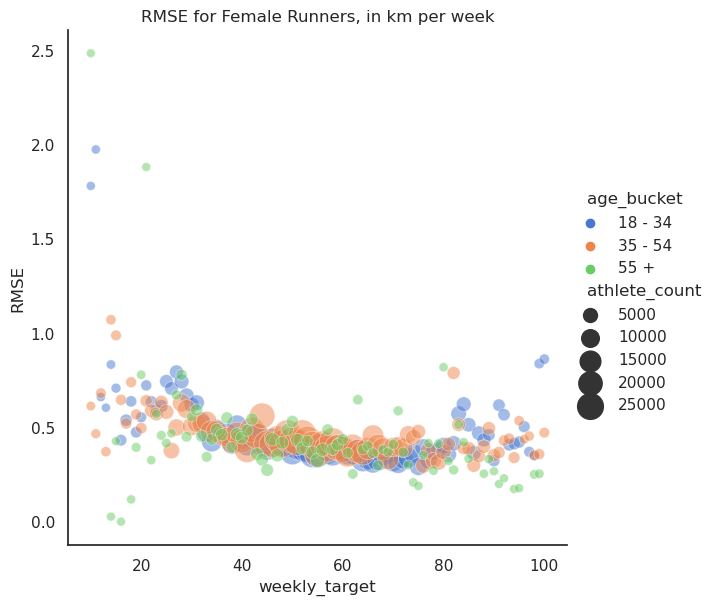

In [37]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

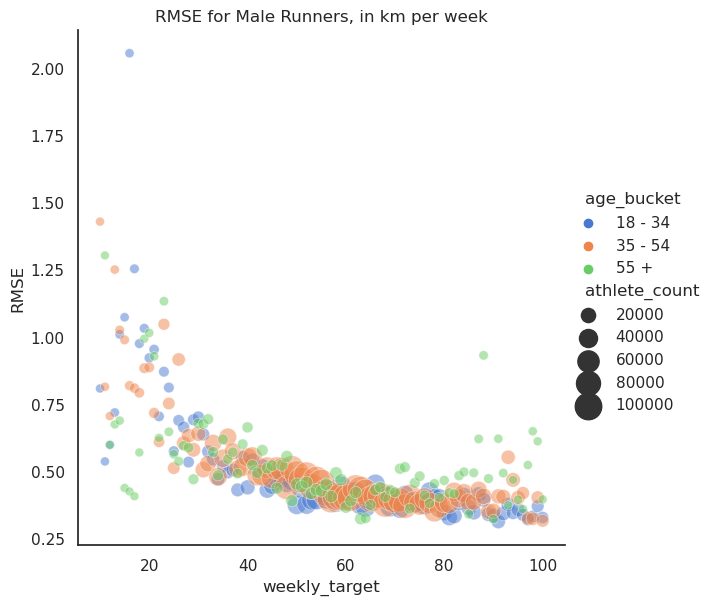

In [38]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

In [23]:
#EOF